In [1]:
#Imports
import sys
import os
import io

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np

import random

import pickle

from ast import literal_eval
from src.model_funcs import run_em, tolerance_sort
from src.plotting_funcs import CB_color_cycle, get_boundaries, plot_ternary_bounds, plot_ternary_axes, plot_bootstrap_bounds
from src.bootstrap_funcs import freq_to_matrix, N_J_bootstrap_em

In [2]:
df_snli = pd.read_csv('../data/final/snli-clean.csv', index_col=0)
df_snli.old_labels = df_snli.old_labels.apply(literal_eval) # since quotes in list elements are escaped

# 1. run EM on full dataset, N=1514, J=100

In [4]:
random.seed(12)
snli_em = run_em(snli_one_hot_arr, K=3)

In [5]:
theta, matched_index = tolerance_sort(snli_em[2], 0.05, reverse=True)

pi = snli_em[1][matched_index]
tau = snli_em[3][:, matched_index]
bounds_original = get_boundaries(pi, theta)

In [3]:
#extract relevant columns
snli_one_hot = df_snli[['e', 'n', 'c']]
snli_one_hot_arr = np.array(snli_one_hot).astype(int)

# 1. EM on varying N and J

In [9]:
snli_annotations = freq_to_matrix(snli_one_hot_arr)

In [10]:
N_J_combinations_list = [(50,5), 
                         (50,25),
                         (50,50),
                         (50,100),
                         (100,100),
                         (250,5), 
                         (250,25), 
                         (250,50), 
                         (250,100),
                         (500,100),
                         (750,5), 
                         (750,25), 
                         (750,50), 
                         (750,100), 
                         (1514,5), 
                         (1514,25), 
                         (1514,50),
                         (1514,75),
                         (1514,100)]

B_matrix_N_J_random_results_list = []
B_matrix_N_J_random_mean_bounds = []
B_matrix_N_J_combinations = []



In [11]:
random.seed(2)

recompute = True

if recompute:
    for comb in N_J_combinations_list:
        print('Combination: ', comb)
        res = N_J_bootstrap_em(Y= snli_one_hot_arr, N_J_comb = comb, snli_annotations = snli_annotations, B=50)

        pi_mean = np.mean(res[0],axis=0)
        theta_mean = np.mean(res[1],axis=0)
        bounds_mean = get_boundaries(pi_mean, theta_mean)

        B_matrix_N_J_combinations.append(comb)
        B_matrix_N_J_random_results_list.append(res)
        B_matrix_N_J_random_mean_bounds.append(bounds_mean)
    with open("../data/bootstrap/b_N_J.pkl", "wb") as f:
        pickle.dump([B_matrix_N_J_combinations, B_matrix_N_J_random_results_list, B_matrix_N_J_random_mean_bounds], f)
else:
    with open("../data/bootstrap/b_N_J.pkl", "rb") as f:
        B_matrix_N_J_combinations, B_matrix_N_J_random_results_list, B_matrix_N_J_random_mean_bounds = pickle.load(f)


Combination:  (50, 5)
Bootstrap iteration:  0


/Users/corneliagruber/DataspellProjects/label-variation-nli/src/model_funcs.py:95: RuntimeWarning: divide by zero encountered in log
  loss += np.sum(weights * (np.log(pi[k]) + np.log(self._multinomial_prob(Y, theta[k]))))
/Users/corneliagruber/DataspellProjects/label-variation-nli/src/model_funcs.py:95: RuntimeWarning: invalid value encountered in multiply
  loss += np.sum(weights * (np.log(pi[k]) + np.log(self._multinomial_prob(Y, theta[k]))))
/Users/corneliagruber/DataspellProjects/label-variation-nli/src/model_funcs.py:96: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(weights * np.log(weights))
/Users/corneliagruber/DataspellProjects/label-variation-nli/src/model_funcs.py:96: RuntimeWarning: invalid value encountered in multiply
  loss -= np.sum(weights * np.log(weights))


Bootstrap iteration:  10
Bootstrap iteration:  20
Bootstrap iteration:  30
Bootstrap iteration:  40
Error in EM
Combination:  (50, 25)
Bootstrap iteration:  0
Error in EM
Bootstrap iteration:  10
Error in EM
Bootstrap iteration:  20
Bootstrap iteration:  30
Bootstrap iteration:  40
Combination:  (50, 50)
Bootstrap iteration:  0
Bootstrap iteration:  10
Bootstrap iteration:  20
Bootstrap iteration:  30
Bootstrap iteration:  40
Combination:  (50, 100)
Bootstrap iteration:  0
Bootstrap iteration:  10
Bootstrap iteration:  20
Bootstrap iteration:  30
Bootstrap iteration:  40
Combination:  (100, 100)
Bootstrap iteration:  0
Bootstrap iteration:  10
Bootstrap iteration:  20
Bootstrap iteration:  30
Bootstrap iteration:  40
Combination:  (250, 5)
Bootstrap iteration:  0
Bootstrap iteration:  10
Bootstrap iteration:  20
Bootstrap iteration:  30
Bootstrap iteration:  40
Combination:  (250, 25)
Bootstrap iteration:  0
Bootstrap iteration:  10
Bootstrap iteration:  20
Bootstrap iteration:  30
Err

N,J= (50, 5)
N,J= (50, 25)
N,J= (50, 50)
N,J= (50, 100)
N,J= (100, 100)
N,J= (250, 5)
N,J= (250, 25)
N,J= (250, 50)
N,J= (250, 100)
N,J= (500, 100)
N,J= (750, 5)
N,J= (750, 25)
N,J= (750, 50)
N,J= (750, 100)
N,J= (1514, 5)
N,J= (1514, 25)
N,J= (1514, 50)
N,J= (1514, 75)
N,J= (1514, 100)


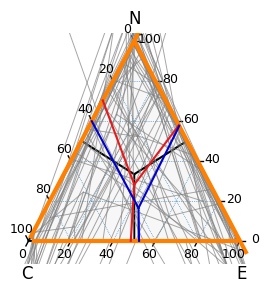

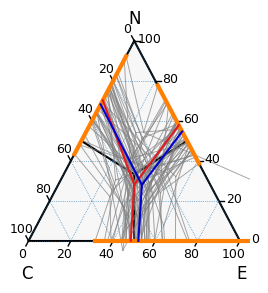

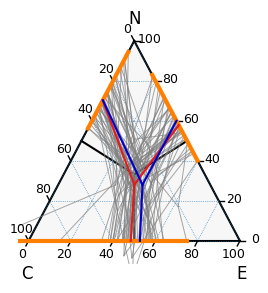

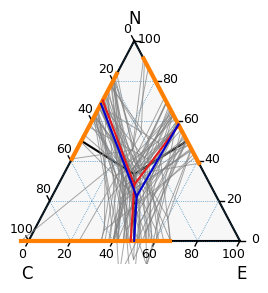

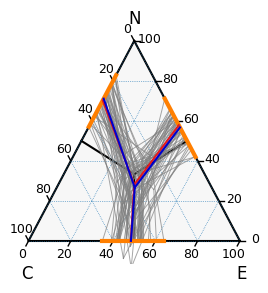

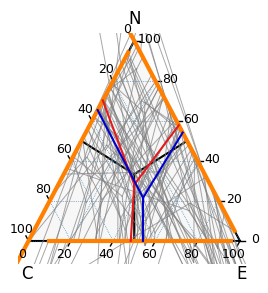

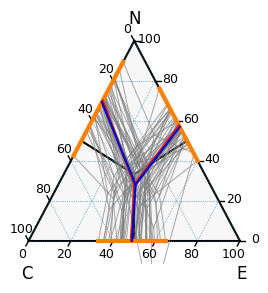

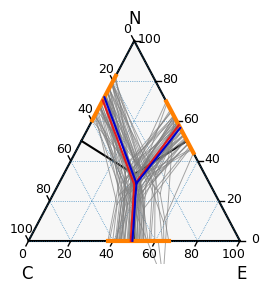

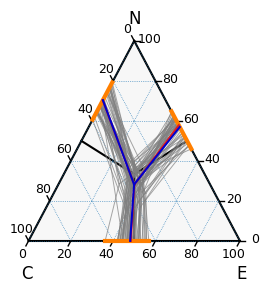

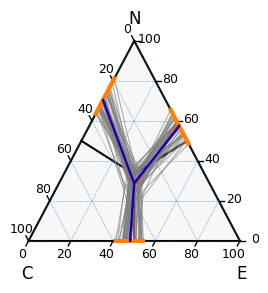

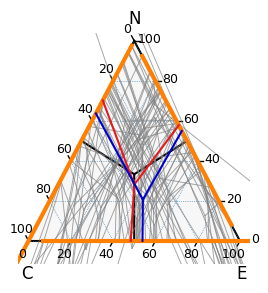

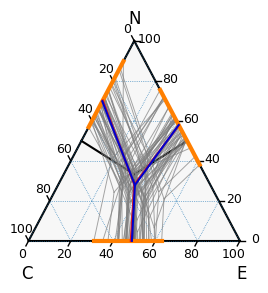

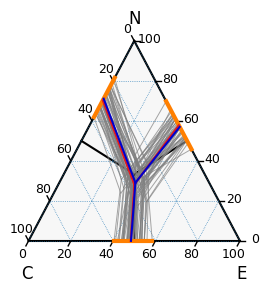

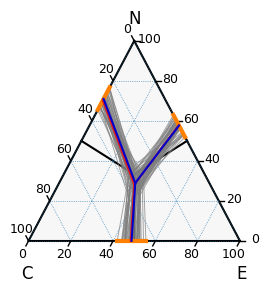

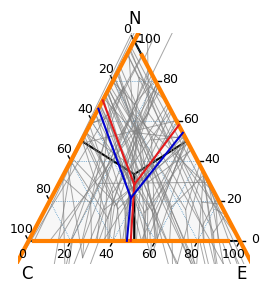

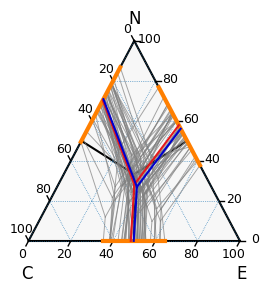

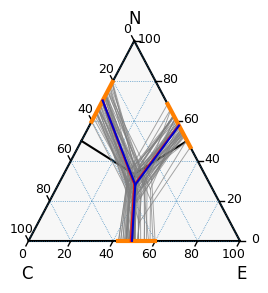

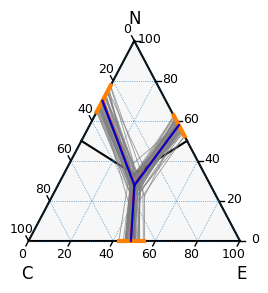

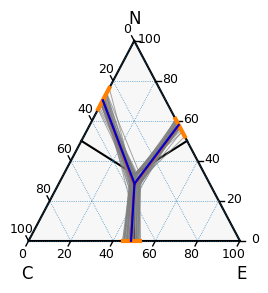

In [12]:
for i in range(len(B_matrix_N_J_combinations)):
    print('N,J=', B_matrix_N_J_combinations[i])
    file_name = '../figs/appendix/N'+ str(B_matrix_N_J_combinations[i][0]) + '_J' + str(B_matrix_N_J_combinations[i][1]) + '_bootstrap.png'
    
    figure, tax = plot_ternary_axes(multiple=20, size=3, labels=["E", "N", "C"], label_offset=-0.15, tick_offset=0.025, weight='roman', tick_fontsize = 9)
    tax = plot_bootstrap_bounds(tax, B_matrix_N_J_random_results_list[i][-2])
    tax = plot_ternary_bounds(tax, pi=pi, theta=theta, bounds_col=CB_color_cycle[7]) # original bounds in red
    pi_mean = np.mean(B_matrix_N_J_random_results_list[i][0],axis=0)
    theta_mean = np.mean(B_matrix_N_J_random_results_list[i][1],axis=0)
    tax = plot_ternary_bounds(tax, pi=pi_mean, theta=theta_mean, bounds_col="mediumblue") # mean bounds in blue
    figure.savefig(file_name, bbox_inches='tight', dpi=300)



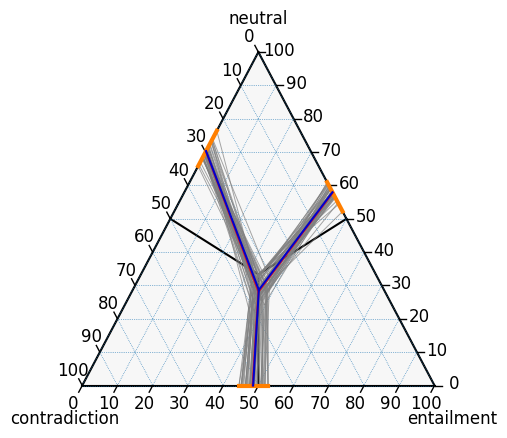

In [14]:
# adjust plotting settings for plot in main part of paper
i = -1 # last one is full dataset

figure, tax = plot_ternary_axes(size = 5)
tax = plot_bootstrap_bounds(tax, B_matrix_N_J_random_results_list[i][-2])
tax = plot_ternary_bounds(tax, pi=pi, theta=theta, bounds_col=CB_color_cycle[7]) # original bounds in red
pi_mean = np.mean(B_matrix_N_J_random_results_list[i][0],axis=0)
theta_mean = np.mean(B_matrix_N_J_random_results_list[i][1],axis=0)
tax = plot_ternary_bounds(tax, pi=pi_mean, theta=theta_mean, bounds_col="mediumblue") # mean bounds in blue
figure.savefig("../figs/full_bootstrap.png", bbox_inches='tight', dpi=300)